## Overview

This notebook presents the tasks developed for the World From Space project. The tasks are divided into two main groups:

- **Task 1**:  Create a single raster image representing the mean of the input NDVI rasters, excluding no-data values from the calculation.

  - The **output raster file** is saved at: "{current_dir}gis_star_task_01/NDVI/brno_mean_ndvi_2023.tiff"
  - The **vegetation map of Brno** is saved at: "{current_dir}/gis_star_task_01/NDVI_Image/task1_brno_mean_ndvi_illustrator-01.png"

- **Task 2**: Reclassify each input EVI raster using a chosen method. For this task, k-means clustering was used to create five classes.
  
  - Each **individual reclassified EVI** is stored in: "{current_dir}/gis_star_task_02/EVI/output"
  - The **mean from the 5 reclassified rasters** is located at: "{current_dir}/gis_star_task_02/EVI\output/vraz_evi_kmeans_mean.tiff".
  - The **final mean raster converted to integer** is located at: "{current_dir}/gis_star_task_02/EVI/output/vraz_evi_kmeans_mean_integer.tiff"

# Setting Up Working Environment

* Select suitable python kernel before installing .yml file
* Create the anaconda environment using an already configured yaml file (takes around around 5 minutes to create the environment)

In [ ]:
!conda env create -f wfs_task_environment.yml

# Packages installed inside anaconda environment, 

* Cell is commented due to redundancy when creating a conda environment with .yaml

In [ ]:
# import sys
# !{sys.executable} -m pip install uv 
# !uv pip install geospatial

# Import installed and custom packages

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import rioxarray

current_dir = os.getcwd()
aux_functions_path = os.path.join(current_dir, "aux_functions.py")
sys.path.append(aux_functions_path)
import aux_functions as af
import importlib
importlib.reload(af)

<module 'aux_functions' from 'c:\\Users\\fuji_\\Desktop\\World-From-Space\\aux_functions.py'>

# Task 1

## Methodology used:

- **1. Raster Stacking:**

  - List all the TIFF files in the input folder.
Use the af.stack_rasters function on the list of TIFF files. This function calculates the mean of all input rasters while clipping them with an input vector file (in this case, a .shp file). If necessary, an additional chunk parameter was added to prevent memory errors during clipping operations.

- **2. Plot Generation:**

  - Generate the mean plot using Matplotlib. Ensure that the x and y labels are appropriately named, depending on whether the data is in a Geographic Coordinate System or a Projected Coordinate System.

- **3. No Data Value Assignment:**

  - Carefully constructed all functions and outputs to assign the correct no data value, which is set to -999.

## Find all TIFF files in a directory and create a list

In [2]:
raster_dir = f"{current_dir}/gis_star_task_01/NDVI"

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

Total number of TIFF files: 4


['c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_01/NDVI\\2023-03-03_09-57-06.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_01/NDVI\\2023-05-22_09-57-09.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_01/NDVI\\2023-08-15_09-57-10.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_01/NDVI\\2023-10-02_10-07-02.tiff']

In [3]:
tiff_files = input_tiffs
output_tiff = f"{current_dir}/gis_star_task_01/NDVI/brno_mean_ndvi_2023.tiff"
aoi_shapefile = f"{current_dir}/gis_star_task_01/Brno_boundaries/Brno_boundaries.shp"

## Calculate Average (mean) of all the four input tiffs

In [9]:
af.stack_rasters(tiff_files, output_tiff, aoi_shapefile, chunk_size=None, operation='mean')

Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_01/NDVI\2023-03-03_09-57-06.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_01/NDVI\2023-05-22_09-57-09.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_01/NDVI\2023-08-15_09-57-10.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_01/NDVI\2023-10-02_10-07-02.tiff
Stacked mean Raster saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_01/NDVI/brno_mean_ndvi_2023.tiff


## Plot NDVI mean

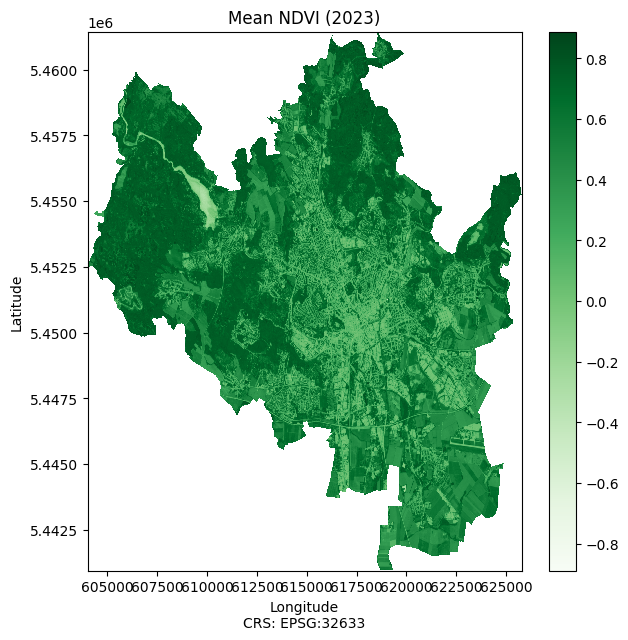

In [12]:
ndvi_raster = rioxarray.open_rasterio(output_tiff)

ndvi_mask = ndvi_raster.where(ndvi_raster != ndvi_raster.rio.nodata)

plt.figure(figsize=(7, 7))
ndvi_mask.plot(cmap='Greens')
plt.title('Mean NDVI (2023)')
plt.xlabel(f'Longitude\nCRS: {ndvi_raster.rio.crs}')
plt.ylabel('Latitude')
plt.show()

# Task 2

## Methodology used:

- **1. Processing TIFF Files:**

  - List all the TIFF files in the input folder and apply the af.process_directory function to this list. Unlike Task 1, each individual TIFF file is processed separately rather than being stacked together in an initial stage.

- **2. K-Means Clustering:**

  - The process_raster function is called to apply K-means clustering on each TIFF file.
  - The cluster labels are then relabeled using the relabel_clusters function. K-means assigns labels arbitrarily, which may not have specific meanings. This function calculates the value range of the five created labels and assigns them based on their minimum values. Consequently, labels ranging from 1 to 5 correspond to increasing NDVI classes.

- **3. Raster Stacking:**

  - After clustering and relabeling, the af.stack_rasters function is applied.
  
- **4. Rounding Values:**

  - To round the float values to integers, the convert_raster_to_integers function is used.

- **5. No Data Value Assignment:**

  - All functions and outputs are carefully constructed to assign the correct no data value, which is set to -998.

## Find all TIFF files in a directory and create a list

In [13]:
raster_dir = f"{current_dir}/gis_star_task_02\EVI"

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

Total number of TIFF files: 5


['c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02\\EVI\\vraz_corn_2020-08-21_EVI.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02\\EVI\\vraz_corn_2022-07-17_EVI.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02\\EVI\\vraz_wheat_2018-05-26_EVI.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02\\EVI\\vraz_wheat_2019-06-03_EVI.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02\\EVI\\vraz_wheat_2021-06-04_EVI.tiff']

In [14]:
input_directory = f"{current_dir}/gis_star_task_02/EVI"
output_directory = f"{current_dir}/gis_star_task_02/EVI/output"

af.process_directory(input_directory, output_directory)

Processing c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI\vraz_corn_2020-08-21_EVI.tiff
Relabeling output saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_corn_2020-08-21_EVI_relabeled.tiff
Processing c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI\vraz_corn_2022-07-17_EVI.tiff
Relabeling output saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_corn_2022-07-17_EVI_relabeled.tiff
Processing c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI\vraz_wheat_2018-05-26_EVI.tiff
Relabeling output saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_wheat_2018-05-26_EVI_relabeled.tiff
Processing c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI\vraz_wheat_2019-06-03_EVI.tiff
Relabeling output saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_wheat_2019-06-03_EVI_relabeled.tiff
Processing c:\Users\fuji_\Desktop\World-From-Spa

## Calculate Average (mean) of all the relabelled rasters

In [15]:
raster_dir = output_directory

input_tiffs = glob.glob(os.path.join(raster_dir, '*.tiff')) + glob.glob(os.path.join(raster_dir, '*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

output_tiff_mean = f"{current_dir}/gis_star_task_02/EVI/output/vraz_evi_kmeans_relabeled_mean.tiff"

input_tiffs

Total number of TIFF files: 5


['c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02/EVI/output\\vraz_corn_2020-08-21_EVI_relabeled.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02/EVI/output\\vraz_corn_2022-07-17_EVI_relabeled.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02/EVI/output\\vraz_wheat_2018-05-26_EVI_relabeled.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02/EVI/output\\vraz_wheat_2019-06-03_EVI_relabeled.tiff',
 'c:\\Users\\fuji_\\Desktop\\World-From-Space/gis_star_task_02/EVI/output\\vraz_wheat_2021-06-04_EVI_relabeled.tiff']

In [16]:
af.stack_rasters(input_tiffs, output_tiff_mean, aoi_shapefile=None, chunk_size=None, operation='mean')

Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_corn_2020-08-21_EVI_relabeled.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_corn_2022-07-17_EVI_relabeled.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_wheat_2018-05-26_EVI_relabeled.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_wheat_2019-06-03_EVI_relabeled.tiff
Processing multiple raster files c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output\vraz_wheat_2021-06-04_EVI_relabeled.tiff
Stacked mean Raster saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output/vraz_evi_kmeans_relabeled_mean.tiff


## Convert raster float values to integer

In [18]:
output_tiff = f"{current_dir}/gis_star_task_02/EVI/output/vraz_evi_kmeans_relabelled_mean_integer.tiff"
af.convert_raster_to_integers(output_tiff_mean, output_tiff)

Raster with integer dataype saved at c:\Users\fuji_\Desktop\World-From-Space/gis_star_task_02/EVI/output/vraz_evi_kmeans_relabelled_mean_integer.tiff


## Plot kmean averaged integer EVI

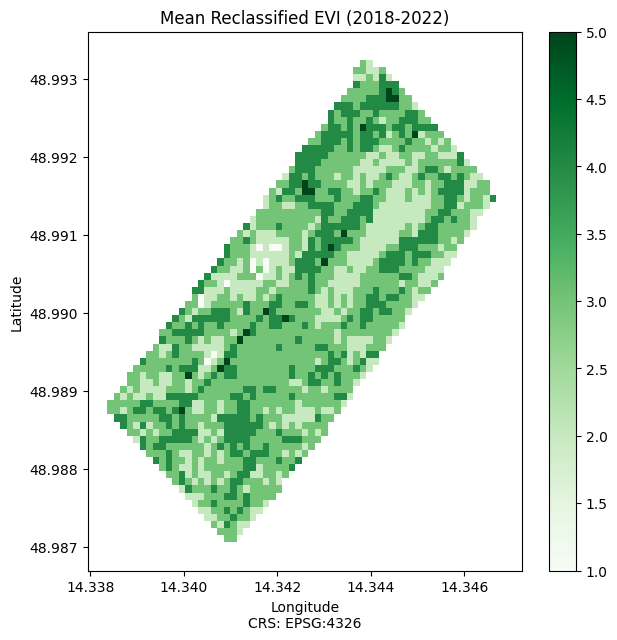

In [19]:
evi_raster = rioxarray.open_rasterio(output_tiff)

evi_masked = evi_raster.where(evi_raster != evi_raster.rio.nodata)

plt.figure(figsize=(7, 7))
evi_masked.plot(cmap='Greens')
plt.title('Mean Reclassified EVI (2018-2022)')
plt.xlabel(f'Longitude\nCRS: {evi_raster.rio.crs}')
plt.ylabel('Latitude')
plt.show()